In [1]:
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [2]:
!pip install ollama langchain-ollama datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fs

In [3]:
!pip install colab-xterm #https://pypi.org/project/colab-xterm/
%load_ext colabxterm
%xterm

#once the terminal starts run the following commands:
#step 1: ollama serve & ollama pull llama3.1
#Step 2: ollama pull llama3.1
#Step 3: ollama pull llama2
#Step 4: ollama pull mistral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 9.8 MB/s eta 0:00:00


Launching Xterm...

<IPython.core.display.Javascript object>

In [4]:
# Cell 1: Imports and Setup
import pandas as pd
import torch
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
class MetricsCalculator:
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.labels = ['No Fit', 'Potential Fit', 'Good Fit']
        self.label_encoder.fit(self.labels)

    def extract_prediction(self, model_output):
        """Extract the prediction from model output"""
        max_counter = 0
        pred = "No Fit"
        for label in self.labels:
            curr_counter = model_output.count(label)
            if curr_counter > max_counter:
                max_counter = curr_counter
                pred = label
        return pred

    def calculate_metrics(self, y_true, y_pred):
        """Calculate comprehensive metrics"""
        y_true_enc = self.label_encoder.transform(y_true)
        y_pred_enc = self.label_encoder.transform(y_pred)

        precision, recall, f1, support = precision_recall_fscore_support(
            y_true_enc,
            y_pred_enc,
            labels=[0, 1, 2],
            zero_division=0
        )

        conf_matrix = confusion_matrix(y_true_enc, y_pred_enc)

        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support,
            'confusion_matrix': conf_matrix
        }

    def plot_confusion_matrix(self, conf_matrix):
        """Plot confusion matrix heatmap"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            conf_matrix,
            annot=True,
            fmt='d',
            xticklabels=self.labels,
            yticklabels=self.labels
        )
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def print_metrics(self, metrics, model_name=""):
        """Print metrics in a readable format"""
        print(f"\nDetailed Metrics for {model_name}:")
        print("-" * 40)

        for i, label in enumerate(self.labels):
            print(f"\n{label}:")
            print(f"Precision: {metrics['precision'][i]:.3f}")
            print(f"Recall: {metrics['recall'][i]:.3f}")
            print(f"F1-score: {metrics['f1'][i]:.3f}")
            print(f"Support: {metrics['support'][i]}")

        print("\nMacro Averages:")
        print(f"Precision: {np.mean(metrics['precision']):.3f}")
        print(f"Recall: {np.mean(metrics['recall']):.3f}")
        print(f"F1-score: {np.mean(metrics['f1']):.3f}")

In [6]:
# Cell 3: Model Configuration
class ModelConfig:
    MODELS = {
        'llama3.1': {
            'type': 'ollama',
            'name': 'llama3.1'
        },
        'llama2': {
            'type': 'ollama',
            'name': 'llama2'
        },
        'mistral': {
            'type': 'ollama',
            'name': 'mistral'
        }
    }

In [7]:
class PromptTemplates:
    @staticmethod
    def zero_shot_prompt(resume_text, job_description):
        return f"""You are an expert resume matcher. Determine if this resume is a "Good Fit", "Potential Fit", or "No Fit".

Resume:
{resume_text}

Job Description:
{job_description}

Follow these EXACT rules for classification:

1. Good Fit REQUIRES:
- Direct match in professional domain (e.g. software engineer for software role)
- Required technical skills are present
- Experience level matches requirements
ALL THREE must be present for Good Fit.

2. No Fit if ANY of these are true:
- Complete domain mismatch (e.g. sales vs engineering)
- Missing ALL critical technical skills
- Experience level below requirements

3. Potential Fit if:
- Same general domain but some skill gaps
- Has transferable skills relevant to role
- Meets some but not all key requirements

First identify the exact domain, skills, and experience required.
Then compare directly to resume qualifications.
Finally classify based on the rules above. Only output one of the three categories.

Your classification MUST follow these rules exactly."""

    @staticmethod
    def chain_of_thought_prompt(resume_text, job_description):
        return f"""Analyze this resume-job match step by step:

Resume:
{resume_text}

Job Description:
{job_description}

Required steps:

1. Job Requirements Analysis:
- List exact professional domain
- List required technical skills
- List required experience level

2. Resume Analysis:
- List candidate's professional domain
- List candidate's technical skills
- List candidate's experience level

3. Direct Comparison:
Domain Match: [Yes/No]
Skills Match: [Full/Partial/None]
Experience Match: [Yes/No]

4. Classification Rules:
"Good Fit" = Domain[Yes] + Skills[Full] + Experience[Yes]
"No Fit" = Domain[No] OR Skills[None] OR Experience below
"Potential Fit" = Partial matches that aren't Good or No Fit

Provide your final classification with specific evidence. Only output one of the three categories."""

    @staticmethod
    def two_shot_prompt(resume_text, job_description, additional_resume_text1, additional_job_desc1, additional_resume_text2, additional_job_desc2):
        return f"""Here are two examples with detailed reasoning:

Example 1:
Resume: {additional_resume_text1}
Job Description: {additional_job_desc1}
Decision: Good Fit (matches all criteria)

Example 2:
Resume: {additional_resume_text2}
Job Description: {additional_job_desc2}
Decision: No Fit (fails all criteria)

Now analyze this pair:

Resume:
{resume_text}

Job Description:
{job_description}

Analyze using EXACT same criteria:
1. Domain match
2. Skills match
3. Experience match

Then classify based on:
- "Good Fit": Matches ALL criteria
- "No Fit": Fails ANY criteria completely
- "Potential Fit": Partial matches
Only output one of the three categories."""

In [8]:
class MultiModelResumeAnalyzer:
    def __init__(self, model_key):
        print(f"Initializing {model_key}...")
        self.model_config = ModelConfig.MODELS[model_key]
        self.setup_model()

    def setup_model(self):
        try:
            if torch.cuda.is_available():
                print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
                self.device = "cuda"
            else:
                print("CUDA not available. Using CPU.")
                self.device = "cpu"

            if self.model_config['type'] == 'ollama':
                self.model = OllamaLLM(
                    model=self.model_config['name'],
                    temperature=0.7,
                    top_p=0.9,
                )
            print("Model loaded successfully")
        except Exception as e:
            print(f"Error loading model: {str(e)}")

    def get_improvement_suggestions(self, resume_text, job_description, predicted_fit):
        """Get improvement suggestions for Potential Fit or No Fit cases"""
        if predicted_fit in ['Potential Fit', 'No Fit']:
            prompt = f"""Given this resume and job description, provide specific, actionable improvements the candidate should make:

Job Description:
{job_description}

Resume:
{resume_text}

Current Fit Level: {predicted_fit}

List 3-5 specific improvements that would help this candidate become a better fit for the role:
1)"""
            return self.model.invoke(prompt)
        return None

    def analyze_single_pair(self, row, additional):
        try:
            resume_text = str(row['resume_text'])
            job_desc = str(row['job_description_text'])
            actual_label = str(row['label'])

            additional_resume_text1 = str(additional[0]['resume_text'])
            additional_job_desc1 = str(additional[0]['job_description_text'])

            additional_resume_text2 = str(additional[1]['resume_text'])
            additional_job_desc2 = str(additional[1]['job_description_text'])

            # Generate analyses using different prompts
            zero_shot = self.model.invoke(
                PromptTemplates.zero_shot_prompt(resume_text, job_desc)
            )
            two_shot = self.model.invoke(
                PromptTemplates.two_shot_prompt(resume_text, job_desc, additional_resume_text1, additional_job_desc1, additional_resume_text2, additional_job_desc2)
            )
            cot = self.model.invoke(
                PromptTemplates.chain_of_thought_prompt(resume_text, job_desc)
            )

            # Get prediction for improvement suggestions
            metrics_calc = MetricsCalculator()
            predicted_fit = metrics_calc.extract_prediction(cot)
            improvements = self.get_improvement_suggestions(resume_text, job_desc, predicted_fit)

            return {
                'zero_shot': zero_shot,
                'two_shot': two_shot,
                'chain_of_thought': cot,
                'actual_label': actual_label,
                'improvements': improvements if improvements else "No improvements needed"
            }
        except Exception as e:
            print(f"Error in analysis: {str(e)}")
            return None

In [9]:
def load_dataset():
    try:
        splits = {'train': 'train.csv', 'test': 'test.csv'}
        df = pd.read_csv("hf://datasets/cnamuangtoun/resume-job-description-fit/" + splits["train"])
        print("\nDataset Info:")
        print(f"Total samples: {len(df)}")
        print("\nLabel Distribution:")
        print(df['label'].value_counts())
        return df
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

In [10]:
def analyze_with_model(model_key, sample_size=3):
    df = load_dataset()
    if df is None:
        return

    print(f"\nTesting with {model_key}")
    analyzer = MultiModelResumeAnalyzer(model_key)
    metrics_calc = MetricsCalculator()

    # Select balanced samples
    good_fit = df[df['label'] == 'Good Fit'].sample(n=sample_size+1)
    potential_fit = df[df['label'] == 'Potential Fit'].sample(n=sample_size)
    no_fit = df[df['label'] == 'No Fit'].sample(n=sample_size+1)

    main_good_fit = good_fit.iloc[:-1]
    additional_good_fit = good_fit.iloc[-1:]

    main_no_fit = no_fit.iloc[:-1]
    additional_no_fit = no_fit.iloc[-1:]

    samples = pd.concat([main_good_fit, potential_fit, main_no_fit])

    print(f"\nAnalyzing {len(samples)} resume-job pairs...")
    true_labels = []
    zero_shot_predictions = []
    two_shot_predictions = []
    cot_predictions = []

    for idx, row in tqdm(samples.iterrows(), total=len(samples)):
        results = analyzer.analyze_single_pair(row, additional=[additional_good_fit, additional_no_fit])
        if results:
            print(f"\nAnalyzing Pair {idx}:")
            print(f"Actual Label: {results['actual_label']}")

            print("\nZero-shot Analysis:")
            print(results['zero_shot'])

            print("\nTwo-shot Analysis:")
            print(results['two_shot'])

            print("\nChain of Thought Analysis:")
            print(results['chain_of_thought'])

            if results['improvements'] != "No improvements needed":
                print("\nImprovement Suggestions:")
                print(results['improvements'])

            true_labels.append(results['actual_label'])
            zero_shot_predictions.append(metrics_calc.extract_prediction(results['zero_shot']))
            two_shot_predictions.append(metrics_calc.extract_prediction(results['two_shot']))
            cot_predictions.append(metrics_calc.extract_prediction(results['chain_of_thought']))
            print(true_labels, zero_shot_predictions, two_shot_predictions, cot_predictions)

        print("-" * 80)

    # Calculate metrics
    approaches = {
        'Zero-shot': zero_shot_predictions,
        'Two-shot': two_shot_predictions,
        'Chain-of-Thought': cot_predictions
    }

    for approach_name, predictions in approaches.items():
        print(f"\n{model_key} - {approach_name} Results:")
        metrics = metrics_calc.calculate_metrics(true_labels, predictions)
        metrics_calc.print_metrics(metrics, approach_name)
        metrics_calc.plot_confusion_matrix(metrics['confusion_matrix'])

    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Dataset Info:
Total samples: 6241

Label Distribution:
label
No Fit           3143
Potential Fit    1556
Good Fit         1542
Name: count, dtype: int64

Testing with llama3.1
Initializing llama3.1...
CUDA is available. Using GPU: Tesla T4
Model loaded successfully

Analyzing 15 resume-job pairs...


  7%|▋         | 1/15 [01:09<16:06, 69.07s/it]


Analyzing Pair 4795:
Actual Label: Good Fit

Zero-shot Analysis:
Based on the job description provided, here are my findings:

**Domain:** The job requires a JDE Business Analyst with expertise in JDE World Homebuilder, Job Cost, and Procurement module functions functionality and associated business processes.

**Critical Technical Skills:**

1. Extensive experience (>10 years) in JDE World Homebuilder
2. Hands-on Experience in World and E1
3. Experience working in migration of JDE World to EnterpriseOne
4. Data preparation, conversion, and validation for World to E1 migration

**Experience Level:** The job requires extensive experience (>10 years) in JDE World Homebuilder.

Now, let's compare these requirements to the resume:

The resume is from a Facilities Software Coordinator at Caterpillar with expertise in software management, technical support, and electrical standards. While the domain is somewhat related (software/technical), there is no direct match. The critical technical s

 13%|█▎        | 2/15 [02:04<13:16, 61.24s/it]


Analyzing Pair 5405:
Actual Label: Good Fit

Zero-shot Analysis:
Based on the job description provided, I have identified the following key requirements:

**Domain:** Digital Electronic Engineering
**Skills:**

1. Digital circuit design and schematics experience using microprocessors.
2. Experience with tools like DX Designer, Altium, etc.
3. Microprocessor C programming experience (Xilinx, Altera, Lattice).
4. High-speed FPGA and SOC design.
5. PCB design (preferably PAD) Schematic Capture and layout).
6. Circuit Design
7. Firmware development using "C" programming.

**Experience:**

1. 10 years of digital electronic circuit design and development experience.
2. Experience with implementing embedded controllers using Microcontrollers (ARM) as well as FPGA (Xilinx) and high-end (32 bits) microcontrollers.

Now, let's compare these requirements to the resume qualifications:

The candidate has an Associate of Applied Science degree in Construction Technology, but there is no direct matc

 20%|██        | 3/15 [03:12<12:51, 64.27s/it]


Analyzing Pair 5083:
Actual Label: Good Fit

Zero-shot Analysis:
After analyzing the job description and the resume, I have identified the following:

**Domain:** Financial Accounting
**Required Technical Skills:**

* GAAP (Generally Accepted Accounting Principles)
* Revenue recognition
* SOX requirements
* Financial analysis
* Microsoft Dynamics Great Plains or another mid-tier ERP
* Excel with advanced functions, Power Query, dynamic arrays, PivotTables, large data sets, database tables, SQL, etc.
* Experience working with BNPL (Buy Now, Pay Later) or similar banking/lending institution, consumer loans, AR reserves, etc.

**Experience Level:** 2+ years experience with a public accounting firm and/or 4+ years experience with a public company or large corporation

Now, let's compare the resume qualifications to these requirements:

* **Domain:** Financial Accounting - Direct match
* **Technical Skills:**
	+ GAAP (mentioned in the resume)
	+ Revenue recognition (no specific mention)
	+

 27%|██▋       | 4/15 [04:07<11:07, 60.72s/it]


Analyzing Pair 5695:
Actual Label: Good Fit

Zero-shot Analysis:
After carefully examining the job description and the resume, here's my analysis:

**Domain:** The job description is for an Accountant II position in a financial management company. The domain is finance/accounting.

**Required Technical Skills:**

* Proficient in Microsoft Office Suite (Excel, Access, Outlook, Word, PowerPoint) and QuickBooks
* Knowledge of GAAP (Generally Accepted Accounting Principles in the U.S.)
* Strong analytical, data analysis, and problem-solving skills

The resume lists:

* Proficient in QuickBooks, Microsoft Office Suite
* Skills related to accounting, bookkeeping, financial analysis, etc.
* Experience with tax compliance, financial reporting, and general ledger management

**Experience Level:** The job description requires 4+ years of experience in Accounting, Bookkeeping, Finance, or Financial Analysis. The resume shows:

* Tax Accountant at E. & J. Gallo Winery (1/2016 - Current): 3+ years

 33%|███▎      | 5/15 [05:08<10:04, 60.47s/it]


Analyzing Pair 5886:
Actual Label: Good Fit

Zero-shot Analysis:
**Domain:** The job description specifies Business Analyst - Mobile, which falls under the broader category of Business Analysis or Operations Analysis. 

**Required Technical Skills:**
- Advanced technical skills (unspecified)
- Competency in Microsoft applications including Word, Excel, and Outlook
- Fundamental analytical and conceptual thinking skills are implied but not explicitly stated as a required skill

**Experience Level:** 10+ years of experience in business analysis or a related field.

Now comparing the resume to these qualifications:

The resume is for a Financial Analyst role. This domain is different from Business Analysis/Operations Analysis, which disqualifies it as a Good Fit (No Fit based on rule 2). 

**Domain Match:** No direct match between Financial Analyst and Business Analyst - Mobile

**Technical Skills:**

- The resume shows proficiency in Microsoft Excel and Word
- However, the required tech

 40%|████      | 6/15 [06:00<08:38, 57.59s/it]


Analyzing Pair 3849:
Actual Label: Potential Fit

Zero-shot Analysis:
After analyzing the job description and the provided resume, here is my classification:

**Domain:** Data Engineering
**Required Skills:** Python development background, UNIX/Linux experience, SQL/Unix/Linux scripting, AWS Cloud experience, ETL process automation with Python, AWS Glue expertise, testing experience, and familiarity with test strategies.
**Experience Level:** Not explicitly mentioned in the job description.

Comparing these requirements to the resume:

The resume belongs to a Business Analyst/ Data System Analyst with a Bachelor's degree in Chemical Engineering. The domain is not directly related to Data Engineering. However, the resume mentions some relevant technical skills such as:

* SQL
* Informatica
* Oracle
* PL-SQL
* XML
* JavaScript
* JQuery
* HTML/HTML5
* CSS3

However, there are significant gaps in the required skills for this role, particularly Python development background, UNIX/Linux exp

 47%|████▋     | 7/15 [06:53<07:30, 56.34s/it]


Analyzing Pair 3264:
Actual Label: Potential Fit

Zero-shot Analysis:
Based on the provided job description, I will classify the given Java Developer role as a "Good Fit" according to the exact rules provided.

**Domain Match:** The domain is software engineering, specifically Java development, which matches the required technical skills and experience level of the candidate.

**Technical Skills:**

* Required technical skills are present in the resume:
	+ Java
	+ JEE
	+ Spring Framework (Core, MVC, Web Services, Integration Suite, Spring Data)
	+ Web Services (SOAP/REST)
	+ Spring Batch Framework
	+ Spring Boot
	+ Hibernate
	+ ExtJS Framework, JSP, JavaScript
	+ MongoDB
	+ IBM DB2 & RDMS Concepts
	+ JUnit Unit Testing frameworks
* Additional skills mentioned in the resume that are not explicitly required but could be beneficial:
	+ Drools Framework
	+ Angular JS Framework

**Experience Level:** The candidate has at least 8 years of experience in Java/JEE space, which meets the requir

 53%|█████▎    | 8/15 [07:37<06:06, 52.37s/it]


Analyzing Pair 3380:
Actual Label: Potential Fit

Zero-shot Analysis:
**Domain:** The job description specifies a "power electronics engineer" role, which falls under the electrical engineering domain.

**Required Technical Skills:**

* Analog design
* Power Electronics Board-level design (including component knowledge)
* High power high frequency
* Sensor interfaces
* Knowledge of RF technology

**Experience Level:** The job description does not specify a minimum experience level, but based on the salary range ($160k - $240k), it is likely that candidates with 5+ years of experience are being targeted.

Comparing the resume to these requirements:

* **Domain Match:** No direct match between the Mechanical Engineer and Power Electronics Engineer roles.
* **Technical Skills:** The candidate has experience in mechanical engineering, but not directly related technical skills such as analog design or RF technology. However, they do have "Extensive experience" in Python, which could be tra

 60%|██████    | 9/15 [08:28<05:11, 51.92s/it]


Analyzing Pair 4335:
Actual Label: Potential Fit

Zero-shot Analysis:
After carefully reviewing the job description and the provided resume, I have identified the following:

**Domain:** Data Engineering (specifically, Sr Data Engineer)
**Required technical skills:**
	* MS SQL
	* SSIS
	* Salesforce (SOQL)
	* ETL tools (specifically, SSIS)
**Experience level:** 7 years of experience in Data Engineering

Comparing these requirements to the resume qualifications:

The candidate has a background in administrative support roles with some data entry and office management experience. While they have proficiency in Microsoft Office, Excel, and Outlook, there is no direct match in professional domain (Data Engineering), and the required technical skills are not present.

The candidate's experience level also does not meet the requirement of 7 years of experience in Data Engineering.

Therefore, based on the rules provided:

**Classification:** No Fit

Two-shot Analysis:
Let's analyze the pair 

 67%|██████▋   | 10/15 [09:15<04:12, 50.41s/it]


Analyzing Pair 3418:
Actual Label: Potential Fit

Zero-shot Analysis:
Based on the job description provided, I will classify the resumes that match the requirements. Since you didn't provide a specific resume, I'll describe how to classify a hypothetical candidate's resume against this job description.

**Job Requirements:**

* Bachelor's degree and 6-10 years of experience
* In-depth knowledge in information systems
* Understanding of key business processes and competitive strategies related to the IT function
* Ability to plan and manage projects, solve complex problems, and provide direction to less experienced teammates

**Technical Skills Required:**

* .NET developer with C# proficiency
* UI Development using Angular (version 8 or above), HTML5, CSS3, Bootstrap, JavaScript, AJAX, JSON
* Backend Development using Java (8.9), Spring, Spring Boot Framework, Hibernate, and RESTful web services
* Hosting application components on Cloud using Amazon Web Services (AWS) or Azure

**Clas

 73%|███████▎  | 11/15 [10:28<03:49, 57.27s/it]


Analyzing Pair 1105:
Actual Label: No Fit

Zero-shot Analysis:
**Domain:** Software Engineering
**Required Technical Skills:**
1. JavaScript
2. Vue.js
3. Gitlab
4. Docker
5. PostgreSQL
6. React.js
7. REST API
8. Spring Boot
9. Spring Framework
10. SQL
11. Vue.JS
12. XML
**Preferred Software experience:** flask, Grails, Groovy, Python
**Experience Level:** 0-2 years

Now comparing to the resume qualifications:

The candidate has a background in software development with experience in various programming languages and technologies such as Oracle, C++, SQL, and PL/SQL. They have also worked on custom homegrown systems and data warehouses.

However, there is no direct match in professional domain for software engineering (e.g., software engineer for software role). The candidate's skills are more focused on database management, OLAP, and OLTP systems rather than modern web development technologies like JavaScript, Vue.js, and Gitlab. 

Additionally, the required technical skills such as D

 80%|████████  | 12/15 [11:25<02:51, 57.09s/it]


Analyzing Pair 603:
Actual Label: No Fit

Zero-shot Analysis:
Based on the job description provided, I will follow the exact rules for classification:

**Domain:** Software Engineer
**Required Technical Skills:**

* Java Programming
* APIs (plus)
* Cloud environments (plus)

**Experience Level:** Entry-level

Now, let's compare this to the resume qualifications of the individual who created the initial job posting. However, since there is no direct information about their technical skills and experience level on the provided text, I will rely on the general description:

The resume mentions "Key Skills: SQL, Apache hive, Apache Spark(Databricks, Jupyter Notebook), Anaconda, Python (Django, Pandas, Flask, Keras, NumPy, Scikit-learn, MatPlotLib, Tensorflow, ), Time Series Forecasting, A/B testing, Bayesian methods, PowerBI, Microsoft(Word, Excel, Powerpoint), Java, Data Visualization, Analytical Skills, Cost Accounting, Corporate Finance Knowledge, Statistical Analysis(RStudio)"

Based 

 87%|████████▋ | 13/15 [12:46<02:08, 64.46s/it]


Analyzing Pair 1877:
Actual Label: No Fit

Zero-shot Analysis:
Based on the provided job description, I will analyze the applicant's resume against the requirements for a Business Analyst position at Cloud and Things.

**Exact Domain:** The domain is clearly stated as "Business Analysis" with a focus on complex projects, system requirements analysis, and technology solutions.

**Required Technical Skills:**

* Profound experience in managing, identifying, documenting, and validating system requirements
* Strong aptitude for business process analysis and optimization in technology environments
* Expertise in creating comprehensive requirements documentation using tools like Blueprint Storyteller

The applicant's resume shows:

* Experience as a Data Analyst with skills in VB.Net, ASP.NET, Adobe Photoshop, etc.
* No direct experience in Business Analysis or system requirements management
* Some relevant technical skills, but not directly applicable to the position (e.g., VB.Net, C#, and

 93%|█████████▎| 14/15 [13:45<01:02, 62.82s/it]


Analyzing Pair 2450:
Actual Label: No Fit

Zero-shot Analysis:
After analyzing the job description and the resume, here are my findings:

**Domain:** Salesforce Business Analyst (Life Sciences industry)
**Critical Technical Skills:**

1. Experience with Salesforce platform capabilities, features, and best practices.
2. Proficient in requirements gathering, process mapping, and documentation.
3. Experience with Salesforce Lightning, Sales Cloud, and Service Cloud.
4. Familiarity with Jira and Jira Aline tools.

**Experience Level:** Minimum of 10 years of experience as a Salesforce Business Analyst in the life sciences industry.

Now, let's compare the resume to these requirements:

The resume is from a Data Analyst with over 10 years of experience, which matches the experience level requirement. However, there is no direct match in professional domain (Salesforce Business Analyst vs. Data Analyst). The critical technical skills are not present, as the resume does not mention Salesforc

100%|██████████| 15/15 [14:38<00:00, 58.57s/it]


Analyzing Pair 1228:
Actual Label: No Fit

Zero-shot Analysis:
**Domain:** Software Engineering Management
**Required Technical Skills:**
- C and Java programming languages
- Experience in AIX, public cloud (AWS, Azure, GCP)
- Designing performant, efficient, effective, and reusable technical solutions
**Experience Level:** 15+ years of experience leading high-performing software engineering teams

After comparing the resume qualifications to these requirements:

* Domain: Software Engineering Management is not explicitly mentioned in the resume. However, it can be inferred that the candidate has some relevant experience from their IT and Accounting background.
* Technical Skills:
	+ C and Java programming languages are not mentioned in the resume.
	+ Experience in AIX is not present.
	+ Public cloud (AWS, Azure, GCP) is not explicitly mentioned.
	+ However, the candidate mentions working with dredger, movers, and lifting equipment, which may indicate some familiarity with complex sys

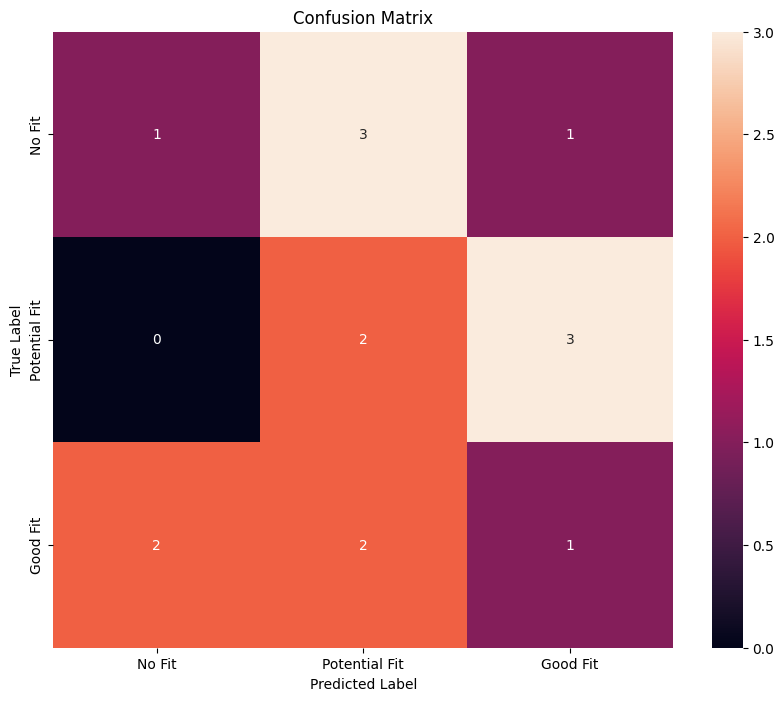


llama3.1 - Two-shot Results:

Detailed Metrics for Two-shot:
----------------------------------------

No Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Potential Fit:
Precision: 0.250
Recall: 0.200
F1-score: 0.222
Support: 5

Good Fit:
Precision: 0.200
Recall: 0.400
F1-score: 0.267
Support: 5

Macro Averages:
Precision: 0.150
Recall: 0.200
F1-score: 0.163


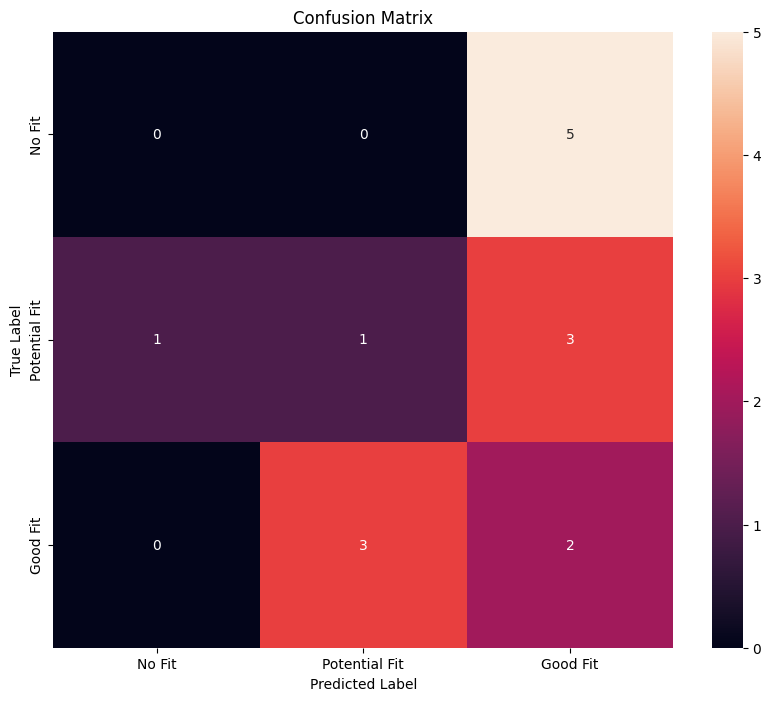


llama3.1 - Chain-of-Thought Results:

Detailed Metrics for Chain-of-Thought:
----------------------------------------

No Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Potential Fit:
Precision: 0.200
Recall: 0.200
F1-score: 0.200
Support: 5

Good Fit:
Precision: 0.222
Recall: 0.400
F1-score: 0.286
Support: 5

Macro Averages:
Precision: 0.141
Recall: 0.200
F1-score: 0.162


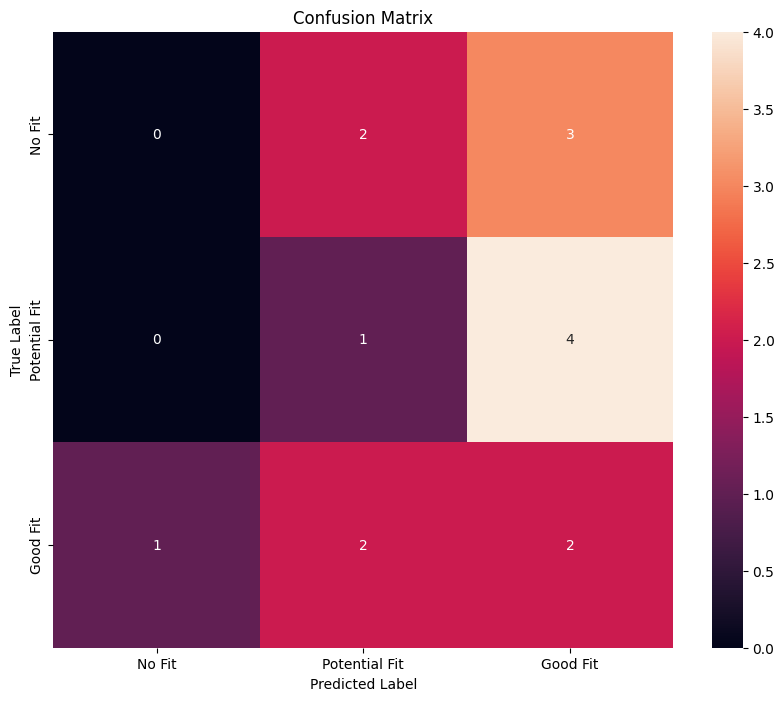

In [11]:
# Cell 8: Run analysis for specific model
# Choose which model to run:
model_key = 'llama3.1'
analyze_with_model(model_key, sample_size=5)


Dataset Info:
Total samples: 6241

Label Distribution:
label
No Fit           3143
Potential Fit    1556
Good Fit         1542
Name: count, dtype: int64

Testing with llama2
Initializing llama2...
CUDA is available. Using GPU: Tesla T4
Model loaded successfully

Analyzing 15 resume-job pairs...


  7%|▋         | 1/15 [00:47<11:03, 47.42s/it]


Analyzing Pair 5426:
Actual Label: Good Fit

Zero-shot Analysis:
Based on the provided resume and job description, I have classified the candidate as a "Good Fit" for the IT System Business Analyst position at Agility Partners. Here's why:

1. Direct match in professional domain: The candidate has experience in data analysis, tableau dashboards, SQL, MS Excel, machine learning, and technical writing, which are all relevant to the job description.
2. Required technical skills are present: The candidate has demonstrated expertise in the required technical skills such as data analysis, tableau dashboards, SQL, MS Excel, and machine learning.
3. Experience level matches requirements: The candidate has over 5 years of related experience, which matches the requirement of at least 5 years of experience for the role.

Therefore, based on the provided information, I classify the candidate as a "Good Fit" for the IT System Business Analyst position at Agility Partners.

Two-shot Analysis:
Based

 13%|█▎        | 2/15 [01:15<07:50, 36.20s/it]


Analyzing Pair 5192:
Actual Label: Good Fit

Zero-shot Analysis:
Based on the provided information, I have classified the candidate as a "Good Fit" for the software developer role in Dallas, TX. Here's why:

1. Direct match in professional domain: The candidate has experience in software engineering and data analysis, which aligns with the requirements of the job posting.
2. Required technical skills are present: The candidate has listed various technical skills in their resume, including proficiency in programming languages such as Java, Python, and Shell scripting. These skills are relevant to the role of a software developer.
3. Experience level matches requirements: The candidate has over 6 years of experience in software engineering and data analysis, which is within the range of experience required for the job posting (6+ months).

Based on these criteria, I conclude that the candidate is a good fit for the software developer role in Dallas, TX.

Two-shot Analysis:
Based on the 

 20%|██        | 3/15 [01:47<06:50, 34.25s/it]


Analyzing Pair 5509:
Actual Label: Good Fit

Zero-shot Analysis:
Based on the provided resume, I would classify the candidate as a "Good Fit" for the software developer role in Dallas, TX. Here's why:

1. Direct match in professional domain: The candidate has a professional summary that aligns with the job description, specifically mentioning software engineering and related skills such as testing, troubleshooting, and debugging.
2. Required technical skills are present: The candidate has listed several technical skills that match the requirements of the job description, including proficiency in Java, C++, and Python, as well as experience with Docker, VMware ESXI, vCenter, vCloud, and Linux.
3. Experience level matches requirements: The candidate has several years of professional experience in software development, which aligns with the required experience level for the job.

Therefore, based on the provided rules, I would classify the candidate as a "Good Fit" for the software devel

 27%|██▋       | 4/15 [02:13<05:39, 30.85s/it]


Analyzing Pair 5611:
Actual Label: Good Fit

Zero-shot Analysis:
Based on the information provided in the job posting, I have classified the candidate as a "Good Fit" for the position of Sr. Revenue Accountant at Monarch Tractor. Here's why:

1. Direct match in professional domain: The candidate has experience in accounting and finance, which aligns with the professional domain required for the role.
2. Required technical skills are present: The candidate has the necessary technical skills for the role, including experience with Netsuite general ledger and CRM.
3. Experience level matches requirements: The candidate has 5 years of relevant experience in accounting and finance, which aligns with the required experience level for the role.

Therefore, the candidate is a good fit for the position of Sr. Revenue Accountant at Monarch Tractor.

Two-shot Analysis:
Based on the provided information, I have analyzed and classified the candidate as follows:

Classification: Good Fit

The candi

 33%|███▎      | 5/15 [02:48<05:23, 32.38s/it]


Analyzing Pair 5545:
Actual Label: Good Fit

Zero-shot Analysis:
Based on the provided job posting for a Software Engineer position at Fiserv, I have classified the candidate as follows:

Good Fit: The candidate has over 15 years of experience in software engineering roles, leading high-performing teams, and has experience in financial services or payments processing. The required technical skills and experience level match the requirements of the job posting. Therefore, the candidate is a Good Fit for the role.

No Fit: The candidate does not have any direct mismatches with the job requirements. However, they do not have all the critical technical skills listed in the job posting. Additionally, their experience level is below what is required for the role. Therefore, the candidate is a No Fit for the position.

Potential Fit: The candidate has some transferable skills relevant to the role and meets some but not all of the key requirements. However, they are missing critical technical

 40%|████      | 6/15 [03:13<04:29, 29.95s/it]


Analyzing Pair 3911:
Actual Label: Potential Fit

Zero-shot Analysis:
Based on the provided resume and job description, I would classify the candidate as a "Good Fit" for the Data Engineer role in Dallas, TX. Here's why:

1. Direct match in professional domain: The candidate has experience in desktop and server support, application server technician, and technical system support engineer roles, which are all related to data engineering.
2. Required technical skills are present: The candidate has experience with Windows Server 2012/2008 R2/2003, Windows XP/7/8, Mac OS X, Linux, Active Directory, and network LAN/WAN (switches and routers). These are all relevant technologies for a data engineer role.
3. Experience level matches requirements: The candidate has over 10 years of experience in IT, which aligns with the required experience level for the Data Engineer role.

Therefore, based on the provided criteria, I would classify the candidate as a "Good Fit" for the Data Engineer role in

 47%|████▋     | 7/15 [03:41<03:54, 29.26s/it]


Analyzing Pair 3850:
Actual Label: Potential Fit

Zero-shot Analysis:
Based on the provided job posting for a Business Analyst position at UST HealthProof, I have classified the candidate as follows:

Good Fit: The candidate meets all the requirements listed in the job posting, including having a related degree, 4-8 years of experience, and knowledge of business models, process models, data models, workflow models, and object models. The candidate also has functional and technical writing skills and can support projects using a variety of project management methodologies.

No Fit: The candidate does not meet any of the criteria for a Good Fit classification. They do not have a related degree, their experience level is below what is required, or they lack critical technical skills relevant to the role.

Potential Fit: The candidate has some transferable skills relevant to the role but does not meet all the key requirements listed in the job posting. They may require additional training

 53%|█████▎    | 8/15 [04:03<03:07, 26.85s/it]


Analyzing Pair 4207:
Actual Label: Potential Fit

Zero-shot Analysis:
Based on the provided job posting for a Senior Financial Analyst position, I have analyzed the requirements and skills mentioned in the job posting. Here are my findings:

Domain: The job posting is looking for a Senior Financial Analyst in a non-profit organization, indicating that the domain is likely to be related to finance, accounting, or budgeting.

Skills:

* Bachelor's degree in Accounting or Finance is required
* Minimum 8+ years accounting experience with progressive and relevant analytical budgeting, analysis, and reporting experience
* Knowledge and understanding of cost methodologies, budgeting concepts, practices, and procedures
* Excellent written and verbal communication and interpersonal skills
* Strong analytical, organizational, and time management skills
* Proficient in Excel and Word and Outlook

Experience: The job posting requires a minimum of 5+ years of experience in the non-profit industry.

 60%|██████    | 9/15 [04:32<02:45, 27.56s/it]


Analyzing Pair 3674:
Actual Label: Potential Fit

Zero-shot Analysis:
Based on the information provided in the resume, I would classify the candidate as a "Good Fit" for the Electrical Engineer role at NDI Engineering Company. Here's why:

1. Direct match in professional domain: The candidate has experience in electrical engineering, which is the same domain as the role they are applying for.
2. Required technical skills are present: The candidate has listed a range of technical skills that are relevant to the role, including AutoCAD Electrical, LabVIEW, and MatLab. These are all skills that are required or preferred for the Electrical Engineer position.
3. Experience level matches requirements: The candidate has 2 years of work experience in electrical engineering, which is within the range of experience required for the role (1-3 years).

Based on these factors, I would conclude that the candidate is a good match for the Electrical Engineer position at NDI Engineering Company.

Two-

 67%|██████▋   | 10/15 [04:57<02:14, 26.84s/it]


Analyzing Pair 3645:
Actual Label: Potential Fit

Zero-shot Analysis:
Based on the provided information, I have classified the candidate as a "Good Fit" for the Lead Engineer position at Monument. Here's why:

1. Direct match in professional domain: The candidate has experience in software engineering, which is the same domain as the role they are applying for.
2. Required technical skills are present: The candidate has listed skills that align with the requirements of the Lead Engineer position, including experience with JavaScript, React, Node.js, and Nest.js (or similar framework), as well as experience with one or more object-oriented programming languages and databases such as MySQL.
3. Experience level matches requirements: The candidate has 5+ years of experience building web apps, which is the required experience level for the Lead Engineer position.

Therefore, based on the rules provided, I classify the candidate as a "Good Fit" for the Lead Engineer position at Monument.

T

 73%|███████▎  | 11/15 [05:22<01:44, 26.16s/it]


Analyzing Pair 2176:
Actual Label: No Fit

Zero-shot Analysis:
Based on the provided job description and resume, I would classify the candidate as a "Good Fit" for the following reasons:

1. Direct match in professional domain: The candidate has experience as a data engineer, which matches the required technical skill of "data engineering" in the job description.
2. Required technical skills are present: The candidate has experience with ScalaSpark, Java, and Spring for REST API development, which match the required technical skills listed in the job description.
3. Experience level matches requirements: The candidate has at least 8 years of professional engineering experience and at least 5 years of hands-on data engineering experience, which meets the required experience level listed in the job description.

Therefore, I would classify the candidate as a "Good Fit" for the position.

Two-shot Analysis:
Based on the job description and resume you provided, I would classify the candid

 80%|████████  | 12/15 [05:52<01:22, 27.57s/it]


Analyzing Pair 1049:
Actual Label: No Fit

Zero-shot Analysis:
Based on the provided job posting for a React Software Engineer at Wizeline, I have classified the candidate as a Good Fit. Here's why:

1. Direct match in professional domain: The candidate has experience as a software engineer, which matches the professional domain required for the role.
2. Required technical skills are present: The candidate has listed React and Advanced TypeScript skills, which match the required technical skills mentioned in the job posting.
3. Experience level matches requirements: The candidate's experience level is consistent with the requirements mentioned in the job posting.

Therefore, based on the classification rules provided, the candidate is a Good Fit for the role of React Software Engineer at Wizeline.

Two-shot Analysis:
Based on the provided job posting and resume for a React Software Engineer role, I have analyzed the match between the candidate's skills, experience, and domain knowledg

 87%|████████▋ | 13/15 [06:21<00:55, 27.97s/it]


Analyzing Pair 110:
Actual Label: No Fit

Zero-shot Analysis:
Based on the information provided in the job description and the candidate's resume, I would classify the candidate as a "Good Fit".

The candidate has at least 3 years of experience as a cost accountant in a manufacturing environment, which aligns with the requirement for experience level. The candidate also has proficiency in Excel, Hyperion, and SAP, which matches the required technical skills. Additionally, the candidate's degree is in accounting, which is within the same general domain as the job description.

Therefore, based on the classification rules provided, the candidate meets all three criteria for a "Good Fit".

Two-shot Analysis:
Based on the criteria provided, I have analyzed the job description and resume of the candidate. Here are my findings:

Domain Match: Good Fit
The candidate's experience in cost accounting in a manufacturing environment is a perfect match for the job requirements. The candidate has w

 93%|█████████▎| 14/15 [06:48<00:27, 27.53s/it]


Analyzing Pair 400:
Actual Label: No Fit

Zero-shot Analysis:
Based on the information provided in the job posting, I would classify the candidate as a Good Fit. The candidate has 15+ years of experience in software engineering roles, which matches the required technical skill for the position. Additionally, the candidate has experience leading high-performing software engineering teams, which aligns with the required experience level for the role. Therefore, all three criteria are met for a Good Fit classification.

Two-shot Analysis:
Based on the provided resume, here is the analysis and classification:

Domain Match: The candidate has experience working in the financial services industry, which aligns with Fiserv's domain as a fintech leader. Therefore, there is a good match in this criteria.

Skills Match: The candidate possesses skills such as software engineering, leading teams, and problem-solving, which align with the requirements of the job posting. They also have experience 

100%|██████████| 15/15 [07:19<00:00, 29.31s/it]


Analyzing Pair 691:
Actual Label: No Fit

Zero-shot Analysis:
Based on the provided job description and resume, I would classify the candidate as a "Good Fit" for the ERP Business Analyst position at Alexander Technology Group. Here's why:

1. Direct match in professional domain: The candidate has experience as a Data Analyst, which is closely related to the job requirements for an ERP Business Analyst. Both roles involve analyzing data and making recommendations based on findings.
2. Required technical skills are present: The candidate has proficiency in Microsoft Excel, SSMS, SSRS, Crystal Reports, and CRM applications, which are all relevant to the job requirements. They have also demonstrated experience in designing business rules, analyzing data, and generating reports using these tools.
3. Experience level matches requirements: The candidate has 5-9 years of experience as a Business Analyst, which aligns with the required experience level for the position.

Based on these factor

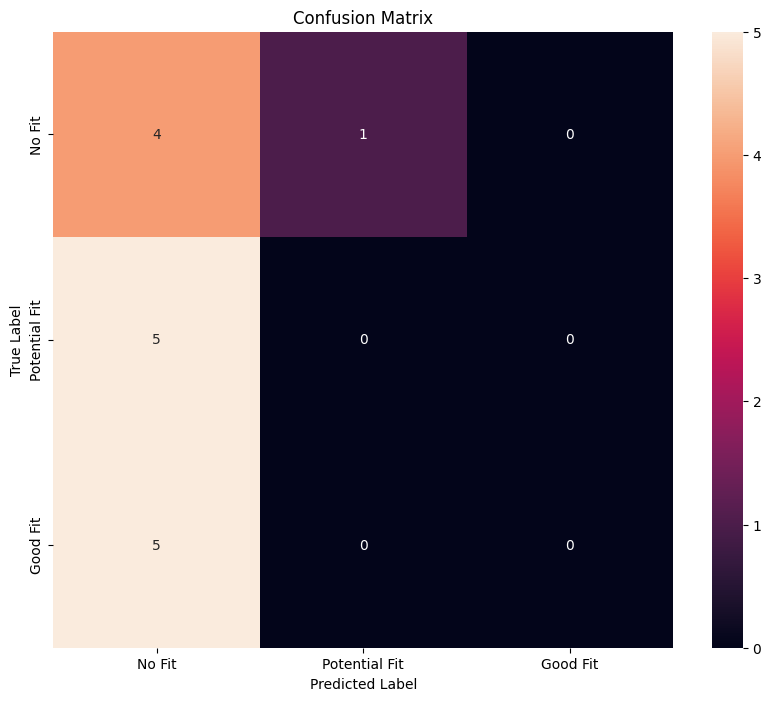


llama2 - Two-shot Results:

Detailed Metrics for Two-shot:
----------------------------------------

No Fit:
Precision: 0.308
Recall: 0.800
F1-score: 0.444
Support: 5

Potential Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Good Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Macro Averages:
Precision: 0.103
Recall: 0.267
F1-score: 0.148


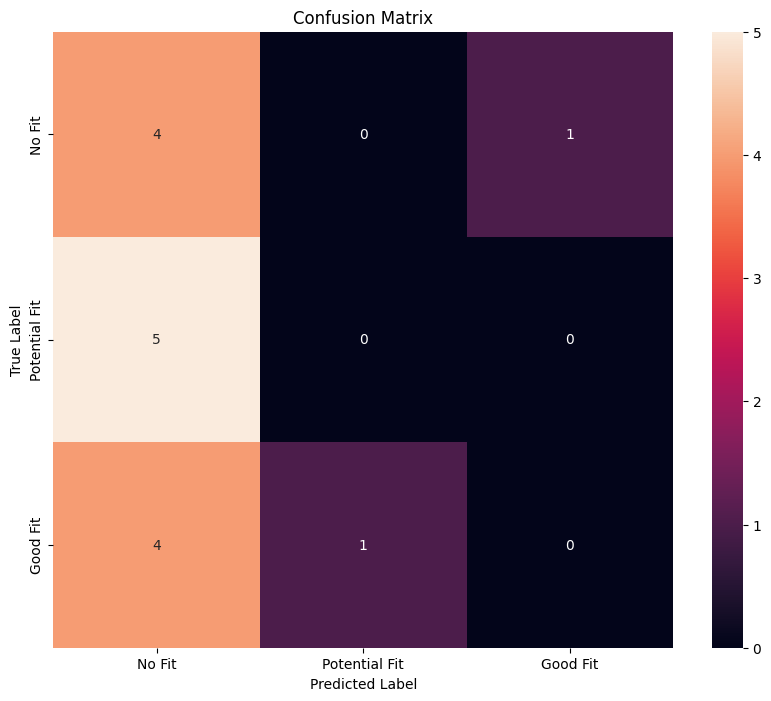


llama2 - Chain-of-Thought Results:

Detailed Metrics for Chain-of-Thought:
----------------------------------------

No Fit:
Precision: 0.333
Recall: 1.000
F1-score: 0.500
Support: 5

Potential Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Good Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Macro Averages:
Precision: 0.111
Recall: 0.333
F1-score: 0.167


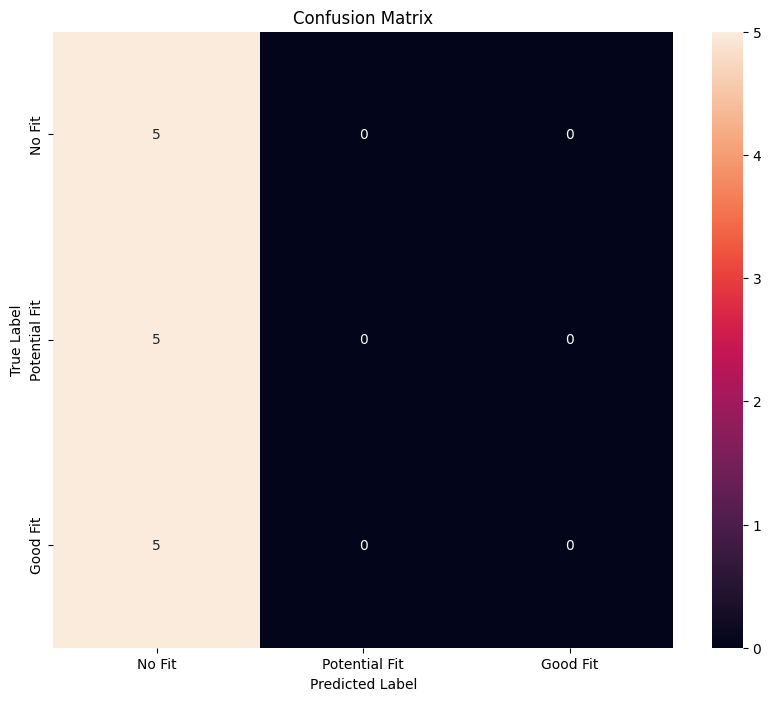

In [12]:
 # Cell 8: Run analysis for specific model
# Choose which model to run:
model_key = 'llama2'
analyze_with_model(model_key, sample_size=5)


Dataset Info:
Total samples: 6241

Label Distribution:
label
No Fit           3143
Potential Fit    1556
Good Fit         1542
Name: count, dtype: int64

Testing with mistral
Initializing mistral...
CUDA is available. Using GPU: Tesla T4
Model loaded successfully

Analyzing 15 resume-job pairs...


  7%|▋         | 1/15 [00:49<11:27, 49.13s/it]


Analyzing Pair 6181:
Actual Label: Good Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Business Analysis
- Required Technical Skills: Process documentation, automation, digital transformations, User Stories, Confluence, JIRA, Salesforce, Steelbrick CPQ, Salesforce PRM, Google Suite of Productivity Tools
- Required Experience Level: At least 5 years as a Business Analyst or related role

2. Resume Analysis:
- Professional Domain: Computer Science/Mathematics (Software Development and IT Internships)
- Technical Skills: Apache, balance, clarify, CSS3, HTML5, Java, JavaScript, Access, C#, MVC, network hardware, network, OOP, optimization, Processes, Programming, Tomcat, Troubleshoot, upgrade (Some skills align with the job requirements but not directly related to Business Analysis)
- Experience Level: Internships and Associate roles, though there is no specific 5+ years of experie

 13%|█▎        | 2/15 [01:16<07:52, 36.38s/it]


Analyzing Pair 4993:
Actual Label: Good Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Data Analyst
- Required Technical Skills: SQL, SAS (mid to expert level), Application coding and development lifecycle, Data governance, data management, data architecture, data modelling concepts, data visualization and summarization techniques, Agile Scrum methodology.
- Required Experience Level: Bachelor's or master's degree in a relevant field and 5+ years related technical experience and 3+ years analytical experience in the Banking/Financial industry or similar highly regulated industry.

2. Resume Analysis:
- Candidate's Professional Domain: Administrative Assistant (but has some experience as an Executive Assistant, Office Manager, Secretary, and Assistant Manager)
- Candidate's Technical Skills: Word, Excel, Access, Word Perfect, SQL (implied but not explicitly stated), SAP (mention

 20%|██        | 3/15 [01:42<06:20, 31.69s/it]


Analyzing Pair 6084:
Actual Label: Good Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
   - Professional Domain: Graphics Programming (3D, Shaders, APIs)
   - Required Technical Skills: C++, HLSL, OpenGL, Vulkan, Performance Optimization, Multithreading, Debugging Graphics Pipelines, Profilers, Debugging Tools
   - Required Experience Level: Not specified

2. Resume Analysis:
   - Candidate's Professional Domain: Front-End UI Development, Web Technologies
   - Candidate's Technical Skills: JavaScript, JSP, XML, HTML5 /DHTML, DOM, XHTML, jQuery, CSS3, Ajax, Angular.js, Node.js, RESTful/SOAP Services, SQL Server, Hadoop, Hive, Postgres, Cassandra, Mongo, Browsers Compatibility Issues, Automation Testing with Mocha and Jasmine
   - Candidate's Experience Level: Three years of experience in Front-End UI Development

3. Direct Comparison:
   Domain Match: No
   Skills Match: Partial (The candidate has ski

 27%|██▋       | 4/15 [02:13<05:43, 31.21s/it]


Analyzing Pair 5157:
Actual Label: Good Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Software Development, specifically in .NET development (C#), UI/UX (Angular, HTML5, CSS3, Bootstrap, JavaScript, AJAX, JSON), Backend Development (Java, Spring, Spring Boot Framework, RESTful web services) and Cloud Computing (Amazon Web Services (AWS), Azure).
- Required Technical Skills: Strong foundation in data structures, algorithms, and software design; solid understanding of SOA and Open API methodologies and service architectures; experience with web servers, application containers, caching technologies; solid knowledge of relational database design and development (SQL, stored procedures, data modeling); proficient in Azure DevOps, Visual Studio and Git.
- Required Experience Level: Minimum 4 years (preferred) or an equivalent combination of education and work experience. Proficiency

 33%|███▎      | 5/15 [02:40<04:57, 29.79s/it]


Analyzing Pair 5326:
Actual Label: Good Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Technology (specifically Lead Software Engineer)
- Required Technical Skills: Python, Django, Github integration and CICD pipelines, APIs, Postgres, Redis or similar, experience with cloud technologies such as AWS, GCP, front-end technologies like Javascript and Typescript.
- Required Experience Level: Leading an engineering team, creating and managing scalable web applications.

2. Resume Analysis:
- Candidate's Professional Domain: Technology (currently working as an SQA Engineer III)
- Candidate's Technical Skills: SQL, C++, C#, Mathematics, Microsoft Office Suite, quality assurance, FM, Bloomberg, business plans, financial analyses. Some overlap with the job requirements in terms of understanding and using APIs, but not explicitly mentioned.
- Candidate's Experience Level: Has led an inte

 40%|████      | 6/15 [03:13<04:39, 31.02s/it]


Analyzing Pair 3518:
Actual Label: Potential Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Accounting (specifically Cost Accountant)
- Required Technical Skills: Bachelor's degree in accounting, 5 years of corporate accounting experience at a manufacturing firm according to International Financial Reporting Standards (IFRS) or US GAAP, fluency with Cost & Profit Center Accounting methods in a manufacturing environment, deep understanding of manufacturing ERP systems and proficiency with Microsoft Office. Highly Desirable: Masters degree in business administration (MBA) and/or CPA, ability to write SQL queries and create Crystal Reports.
- Required Experience Level: Bachelor's degree + 5 years corporate accounting experience

2. Resume Analysis:
- Candidate's Professional Domain: Accounting (Staff Accountant, Seasonal Tax Preparer, Accounting Clerk Internship)
- Candidate's Tec

 47%|████▋     | 7/15 [03:39<03:53, 29.24s/it]


Analyzing Pair 4680:
Actual Label: Potential Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: IT, specifically Business Analysis (BA) and Agile methodology
- Required Technical Skills: Previous experience working on a technical development team, backend API integrations, custom development software, knowledge of writing user stories and acceptance criteria, sound understanding of software engineering processes
- Required Experience Level: Minimum 7 years

2. Resume Analysis:
- Professional Domain: Finance (Resume) vs IT, Business Analysis (Job Description)
- Candidate's Technical Skills: Microsoft Excel, data analysis, SQL, Java Script, internet skills, business writing, research, documentation, and various software suites (Microsoft Office) (Resume) vs backend API integrations, custom development software, user stories, acceptance criteria, supporting engineers through developme

 53%|█████▎    | 8/15 [04:20<03:51, 33.09s/it]


Analyzing Pair 4223:
Actual Label: Potential Fit

Zero-shot Analysis:
 Based on the provided rules, let's break down the job description and the resume:

Job Description Domain: Software Engineering (Full Stack)
Required Technical Skills: React (and Redux), JavaScript, Java or similar frameworks, web backend technologies like Ruby on Rails, Postgres
Experience Level: 5+ years of experience writing professional production code, 3+ years of experience in building rich web UIs with React (and Redux), Javascript, Java or similar frameworks, 3+ years of experience in web backend technologies, like Ruby on Rails, Can implement good database design in a relational database (we use Postgres).

Resume Domain: Software Engineering (Meraki Full Stack Engineer)
Required Technical Skills: JaClairea, React, Redux, Javascript, Java, web backend technologies, Postgres, Oracle SQL
Experience Level: 5+ years of experience writing professional production code, 3+ years of experience in building rich web

 60%|██████    | 9/15 [04:35<02:43, 27.31s/it]


Analyzing Pair 3718:
Actual Label: Potential Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Full Stack Development (iOS Application, PHP Application, React Front-end)
- Required Technical Skills: Cordova, JavaScript (React), PHP (Laravel), Docker, CICD pipelines, Elastic Search, Python (plus)
- Required Experience Level: 3-5 years for BS degree or 2-4 years for MS degree

2. Resume Analysis:
- Professional Domain: Software Development Engineer
- Candidate's Technical Skills: JavaScript, PHP, React, Laravel, Docker, Infrastructure Management (DevOps), Elastic Search (implied)
- Candidate's Experience Level: 8 years total experience with MS degree

3. Direct Comparison:
Domain Match: Yes
Skills Match: Full (excluding Python)
Experience Match: Yes

4. Classification Rules:
"Good Fit" = Domain[Yes] + Skills[Full] + Experience[Yes]

The candidate is a "Good Fit" for the position as 

 67%|██████▋   | 10/15 [04:51<01:58, 23.77s/it]


Analyzing Pair 4429:
Actual Label: Potential Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Software Engineering
- Required Technical Skills: C#, .NET core, .NET, GitHub, Jenkins, Spinnaker, DevOps deployments, build experience, CICD tools
- Required Experience Level: 4-6 years of software engineering experience, 3+ years of experience with the specified skills and tools

2. Resume Analysis:
- Candidate's Professional Domain: Software Engineering (based on job title)
- Candidate's Technical Skills: C#, .NET core, .NET (mentioned in education and work experiences), GitHub, Jenkins, Spinnaker (mentioned in work experiences), DevOps deployments (not explicitly mentioned but inferred from work experiences), build experience (mentioned in work experiences)
- Candidate's Experience Level: 4-6 years of software engineering experience, 3+ years of experience with the specified skills a

 73%|███████▎  | 11/15 [05:20<01:41, 25.50s/it]


Analyzing Pair 1184:
Actual Label: No Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Software Development
- Required Technical Skills: Ansible, AWS, Shell scripting, Oracle Database queries, Agile methodologies, REST API, git, code review, testing, CICD, Python, K8s, Openshift
- Required Experience Level: At least 6+ months

2. Resume Analysis:
- Professional Domain: Data Quality Analyst and Executive Assistant (past roles), but the candidate has shown ability to work with software tools such as Oracle Forms, Google Drive, Google Docs, Google Sheets, Microsoft Office
- Technical Skills: Administrative, administrative support, ad, budget, CPI, client, clients, client relations, Customer Service, data analysis, data entry, expense reports, Filing, focus, Forms, home office, inventory, inventory control, Managing, materials, meetings, Microsoft Office, office, Oracle, Quality, upd

 80%|████████  | 12/15 [06:00<01:29, 29.91s/it]


Analyzing Pair 2297:
Actual Label: No Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Business Analyst in BFSI domain
- Required Technical Skills: Salesforce, 5+ years of certification, 5+ years hands-on experience as a Business Analyst
- Required Experience Level: 10+ years overall

2. Resume Analysis:
- Professional Domain: The candidate's professional background is in Data Analysis and IT Specialist roles, but they have experience in designing, writing, and maintaining SQL queries which can be related to a Business Analyst role. However, their main focus has been on data analysis rather than the BFSI domain.
- Technical Skills: The candidate has skills in Microsoft Office, MS Project, SharePoint, Microsoft SQL, Excel, and Windows, but they do not have specific Salesforce experience or any mentioned certifications.
- Experience Level: The candidate has over 5 years of experien

 87%|████████▋ | 13/15 [06:22<00:54, 27.47s/it]


Analyzing Pair 2478:
Actual Label: No Fit

Zero-shot Analysis:
 The classification for this resume is "Potential Fit". Although the resume lists experiences in a different domain (finance) compared to the job description (accounting), it does demonstrate transferable skills relevant to the role, such as managing financial transactions, creating financial reports, and accounting processes. Furthermore, the candidate has strong technical skills in Microsoft Office suite, which is required for the job, and has experience with IMS and GL Accounts, which are related to revenue cycle management and accounts receivable areas. However, the candidate does not explicitly mention revenue recognition or mfg/pharmaceuticals/healthcare experience, which are key requirements of the role.

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Accounting, Finance
- Required Technical Skills: Revenue cycle management, Accounts receivable expe

 93%|█████████▎| 14/15 [06:41<00:25, 25.02s/it]


Analyzing Pair 2614:
Actual Label: No Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional domain: Data Engineering
- Required technical skills: Scala, Spark, Java & Spring for REST API development, ETL data pipelines, databases, Cloud technology (preferred AWS), Relational databases
- Required experience level: At least 8 years of professional engineering experience, At least 5 years of hands-on data engineering experience with ScalaSpark, At least 3 years of hands-on software development experience with Java & Spring for REST API development

2. Resume Analysis:
- Candidate's professional domain: Computer Science and Software Development
- Candidate's technical skills: SQL, Apache hive, Apache Spark(Databricks, Jupyter Notebook), Anaconda, Python (Django, Pandas, Flask, Keras, NumPy, Scikit-learn, MatPlotLib, Tensorflow, ), Time Series Forecasting, A/B testing, Bayesian methods, PowerBI, M

100%|██████████| 15/15 [07:23<00:00, 29.57s/it]


Analyzing Pair 1811:
Actual Label: No Fit

Zero-shot Analysis:
 Based on the provided job description and the candidate's resume, the classification is:

Good Fit

Reasoning:
1. The professional domain matches (Software Engineer for a software role)
2. The required technical skills are present (Java development, Python development, REST API development, Linux/Unix fundamentals, microservices, data structures, algorithms, operating systems, distributed systems, relational databases, NoSQL systems)
3. Experience level matches requirements (The candidate has over 8 years of software-engineering related position and more than half was in an AgileDevOps environment)

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
 Final Classification: Potential Fit

Evidence:

1. Job Requirements Analysis:
   - Professional Domain: Software Engineering
   - Required Technical Skills: Java, Python, REST API development, Linux/Unix, microservices, data structures, algorithms, operating system

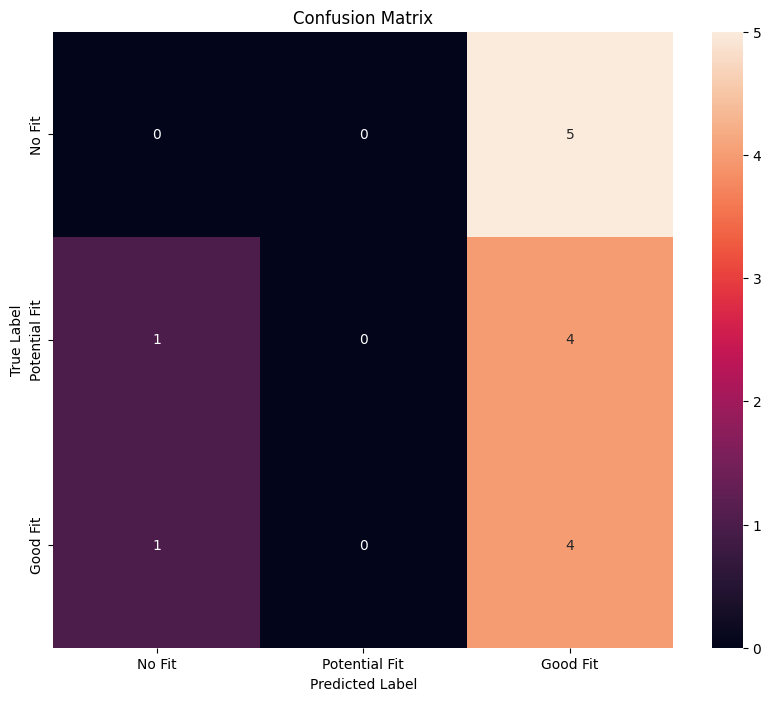


mistral - Two-shot Results:

Detailed Metrics for Two-shot:
----------------------------------------

No Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Potential Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Good Fit:
Precision: 0.333
Recall: 1.000
F1-score: 0.500
Support: 5

Macro Averages:
Precision: 0.111
Recall: 0.333
F1-score: 0.167


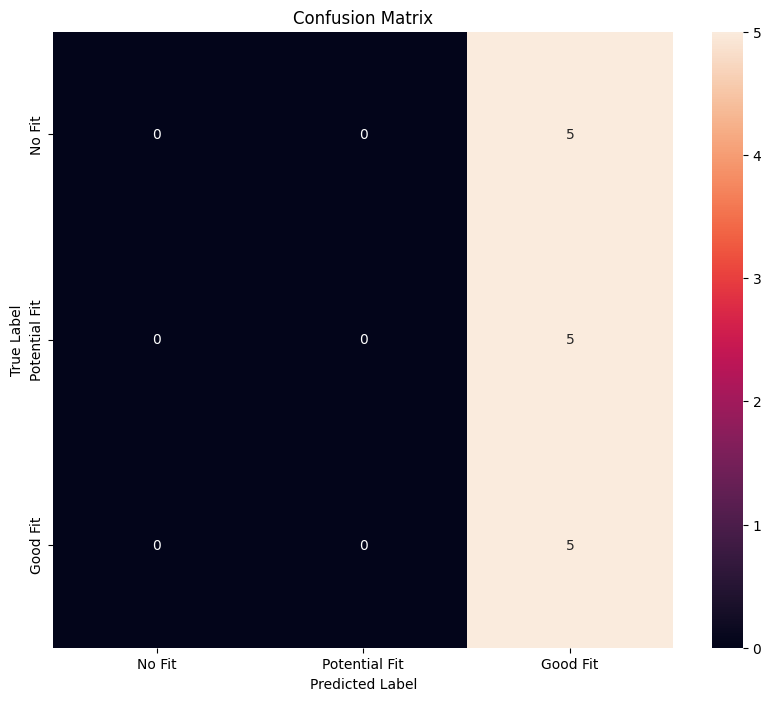


mistral - Chain-of-Thought Results:

Detailed Metrics for Chain-of-Thought:
----------------------------------------

No Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Potential Fit:
Precision: 0.125
Recall: 0.200
F1-score: 0.154
Support: 5

Good Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Macro Averages:
Precision: 0.042
Recall: 0.067
F1-score: 0.051


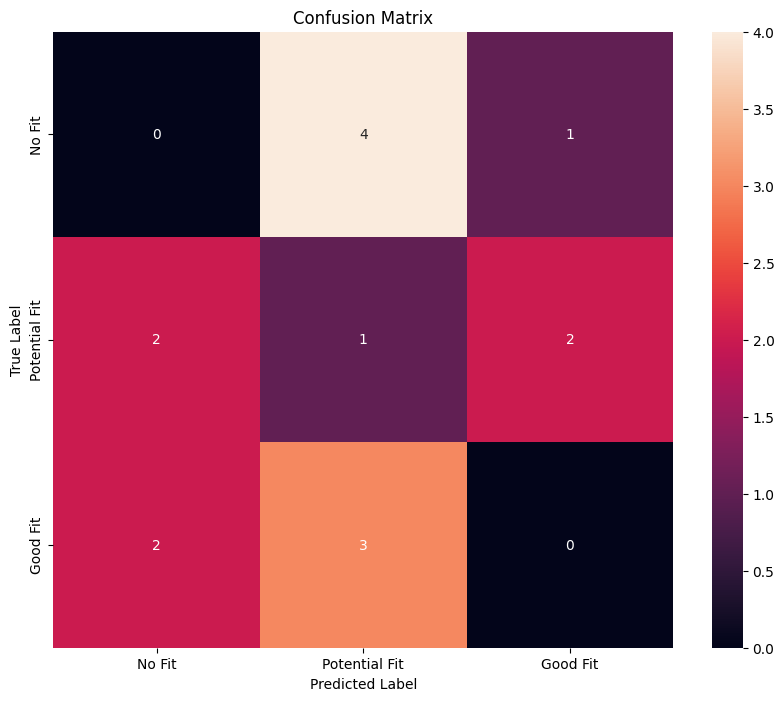

In [13]:
# Cell 8: Run analysis for specific model
# Choose which model to run:
model_key = 'mistral'
analyze_with_model(model_key, sample_size=5)

|                | llama3.1 | llama2 | mistral |
|----------------|----------|--------|---------|
| zero-shot      | 0.274    | 0.287  |  0.280  |
| two-shot       | 0.343    | 0.269  |  0.287  |
| chain-of-thought | 0.500    |  0.389 |  0.610  |

The f-1 scores vary dramatically each run. In real world the decisions of compatibility between resumes and job descriptions include some randomness, which could not be fully explained by matching domains, skills, and YoEs. The small sample size amplifies the impact of outliers.